# Introduzione

Il package `covid_analysis` permette di effettuare il caricamento di un dataset e di analizzarlo usando diverse
tecniche:

Il dataset, che può essere reperito in modi differenti, è composto da una lista di oggetti, contenente ciascuno 7
attributi:
1. nome della nazione
2. contagi giornialieri
3. guarigioni giornaliere
4. decessi giornalieri
5. contagi totali
6. guarigioni totali
7. decessi totali

## Caricamento del file di configurazione

L'analisi viene condotta a partire da un file di configurazione.
Tale file è in formato json, viene letto e tradotto in una `namedtuple` ricorsiva. Così, se ad esempio il file
fosse definito come segue:
```
{
  a: {
    b: {
      c: 1
    }
  }
}
```
sarebbe possibile accedere all'elemento `c`, semplicemente scrivendo:
```
value = a.b.c
```
La classe `Config` è implementata come singleton

In [16]:
from covid_analysis.model import Config


config = Config.get_instance().load('config.json')

## Generazione della repository factory
E' possibile caricare dati da diverse sorgenti, mediante un'interfaccia comune `CovidRepositoryInterface`.
Sono state definite diverse implementazioni, tutte elencate nel file di configurazione:
```
{
    ...
    "available_repository_types" : {
        "api": "ApiCovidRepository",
        "dummy" : "DummyCovidRepository",
        "storage": "StorageCovidRepository"
        "sqlite": "SqliteCovidRepository"
    },
    ...
}
```

Inoltre per ogni repository, il file di configurazione prevede un campo con un insieme di valori per configurare ciascun
repository. Pertanto, se ad esempio esistessero delle chiavi del tipo:
```
{
...
    "available_repository_types" : {
        "api": "ApiCovidRepository",
        ...
    },

    ...

    "api" {
        "basepath": "http://abc.de"
    }
}
```
il repository `api` verrebbe costruito automaticamente come segue:

`repo = ApiCovidRepository(basepath="http://abc.de")`

Tuttavia, per una inizializzazione semplice dei repository, è stata definita la classe `CovidRepositoryFactory`, che
crea i Repository già inizializzati usando gli opportuni parametri di configurazione.

`CovidRepositoryFactory` viene creata a partire dalla configurazione tramite la funzione
`create_repository_factory(config)` . che registra i vari driver tramite i parametri passati in configurazione:

In [17]:
from covid_analysis import create_repository_factory

covid_data_factory = create_repository_factory(config)

Una volta generata la factory, i repository completamente inizializzati possono essere reperiti semplicemente
richiamando il driver richiesto.

In [18]:
repo = covid_data_factory('api')

Il driver `api` ha la particolarità di salvare i dati letti da un endpoint rest in una cache temporanea su disco.
Ciò permette di ridurre i tempi di latenza. Tale cache è implementata tramite un decorator, si rimanda alla definizione
della classe per i dettagli implementativi.

In [19]:
import time

def measure(func):
    """Simple function to evaluate a function execution time"""
    start_time = time.time()
    func()
    print(f"Execution time: --- {(time.time() - start_time)} seconds ---")

measure(repo.load) # first execution without cache: slower
measure(repo.load) # second execution with cache: faster

Execution time: --- 0.4423940181732178 seconds ---
Execution time: --- 0.0007746219635009766 seconds ---


## Analisi dei dati
La classe `RatioAnalyzer` è demandata all'analisi dei rapporti dati caricati da un repository, in termini di
- Contagi
- Guarigioni
- Decessi

In [20]:
from covid_analysis.service import RatioAnalyzer

analyzer = RatioAnalyzer(repo=repo)

## Estrazione dei rapporti fra dati giornalieri e totali
Lo scopo principale di `RatioAnalyzer` è quello di estrarre i rapporti fra i dati quotidiani e totali, tramite
i quali è possibile stabilire la variazione giornaliera di
- contagi
- guariti
- decessi

In [21]:
ratios = analyzer(new_confirmed_ratio=True, new_recovered_ratio=True, new_deaths_ratio=True)
ratios['Italy']

{'new_confirmed_ratio': 0.0008608879562602696,
 'new_recovered_ratio': 0.0006923189039498615,
 'new_deaths_ratio': 0.00022948280313244025}

## Generazione istogrammi rapporti fra valori giornalieri e totali, relativamente

Tramite la stessa classe è inoltre possibile visualizzare i sopracitati rapporti tramite un grafico ad istogramma.

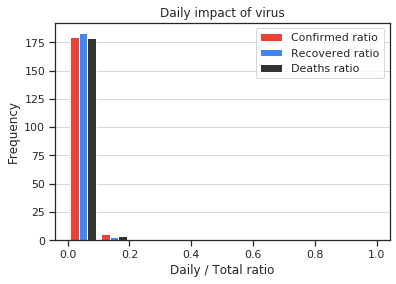

In [22]:
analyzer.plot_ratio_histogram()

## Suddivisione dei paesi in zone di attività del contagio
Una semplice categorizzazione delle aree di contagio mondiali può essere operata sulla base del clustering dei valori
dei rapporti precedentemente ottenuti. L'algoritmo di clustering usato è il `k-means`
Il parametro nominale opzionale `save_to` indica il file dove andare a salvare i nomi della nazioni categorizzati

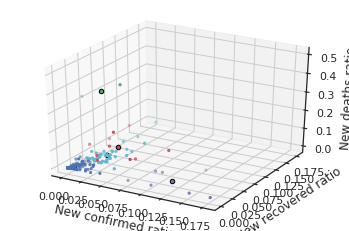

In [23]:
clusters = analyzer.cluster_countries(num_cluster=5, draw_plot=True, save_to=config.classification_results_file)

## Visual data analysis
i dati vengono elaborati per la visualizzazione grafica tramite la classe `DataInspector`, che accetta anche un
parametro di filtraggio, del tipo `AbstractFilter`.
I filtri realizzati sono di tre tipi:
- `FIlterByName`: a titolo di esempio, filtra le nazioni che non contengono nel loro nome una particolare sottostringa
- `FilterByThreshold`: filtra le nazioni che abbiano l'attributo `field` inferiore/superiore a `threshold`, in base
al parametro `reversed`, rispettivamente `True/False`
- `ComposedFilter`, applica un numero arbitrario di filtri base, passati nella tupla `base_filters`. Tale filtro
permette di realizzare filtri complessi a partire da quelli base. Ad esempio è possibile filtrare i valori in un range,
mediante la composizione di due `FilterByThreshold`, uno dei quali invertito.

La factory `FilterFactory` fornisce una semplice interfaccia per la creazione di filtri.

In questo esempio, vengono filtrate le nazioni che abbiano, al tempo stesso:
- meno di 1000 nuovi contagi
- più di 100 nuovi guariti
- Un numero di morti compreso fra 10000 e 1000000

Nota: tutti i metodi della classe hanno un parametro nominale opzionale `save_figure_to`, che, se valorizzato, serve
a salvare su file il grafico risultante.

In [24]:
from covid_analysis.service import DataInspector
from covid_analysis.model.filters import FilterFactory

custom_filter = FilterFactory.compose(
            FilterFactory.byUpperBound("new_confirmed", 1_000),
            FilterFactory.byLowerBound("new_recovered", 100),
            FilterFactory.byRange('total_deaths', 10_000, 1_000_000)
        )

inspector = DataInspector(
        repo=covid_data_factory("api"),
        filter=custom_filter
    )

### Visualizzazione della heat map relativa alla correlazione delle sei grandezze disponibili

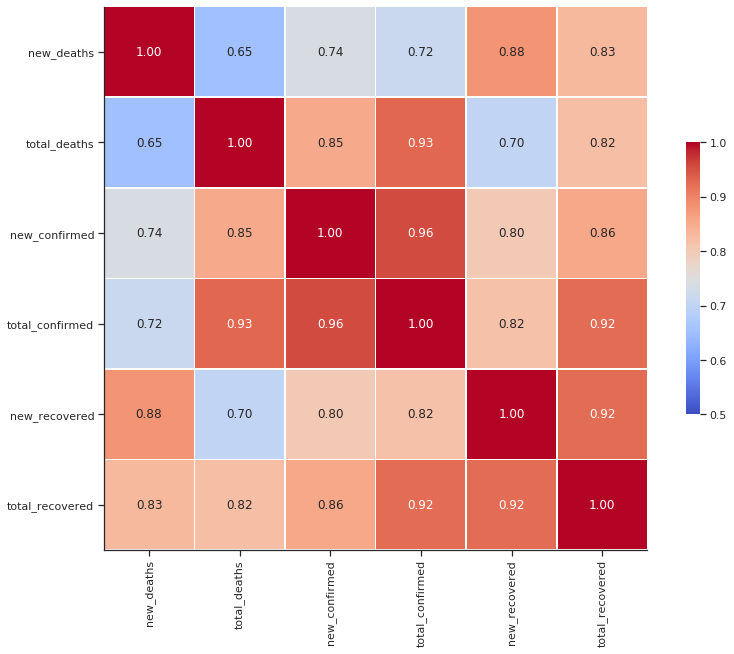

In [25]:
inspector.heat_map(save_figure_to=config.plot_destination_folder + "heatmap.png")

### Visualizzazione scatter plot a coppie (istogrammi delle distribuzioni sulla diagonale)

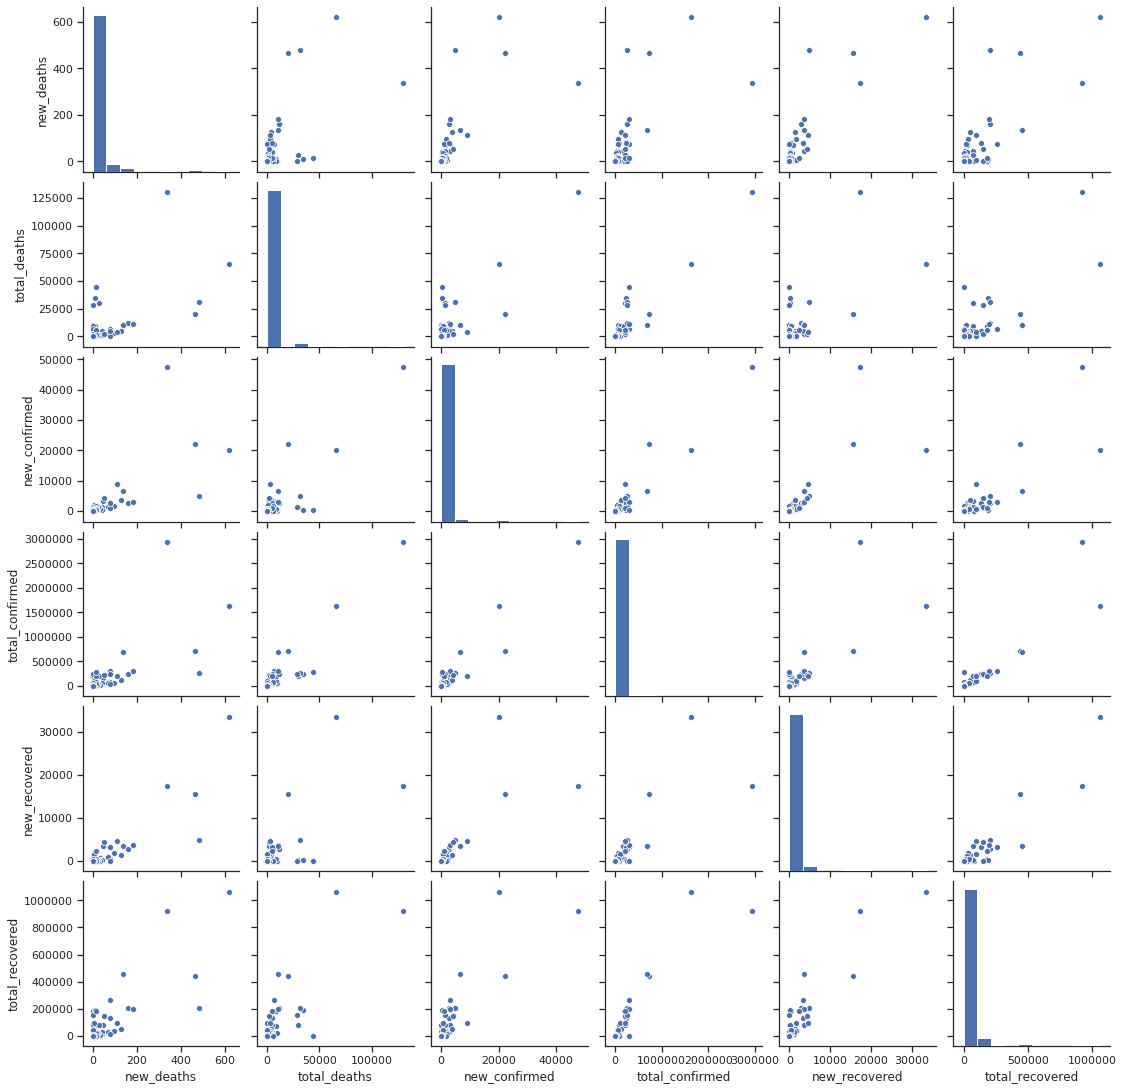

In [ ]:
inspector.pairplot(save_figure_to=config.plot_destination_folder + "pairplot.png")

### Visualizzazione swarm
In questa visualizzazione vengono mostrate solo le N nazioni aventi la metrica definita in `show` maggiore della media
globale (questo filtro solo per evitare di ammassare troppe nazioni, aventi perlopiù dati trascurabili).

Inoltre, vengono evidenziate con delle annotazioni gli stati con il valore massimo e minimo

In [ ]:
inspector.swarmplot(about='total_deaths', save_figure_to=config.plot_destination_folder + "total_deaths_swarm.png")
inspector.swarmplot(about='new_deaths')
inspector.swarmplot(about='total_recovered')
inspector.swarmplot(about='new_recovered')
inspector.swarmplot(about='total_confirmed')
inspector.swarmplot(about='new_confirmed')

## Salvataggio dei dati su disco e successivo recupero

I dati dei contagi possono essere salvati su file, ottenendo un'istanza di `StorageCovidRepository`, sempre utilizzando
la factory passando la chiave `storage`. `StorageCovidRepository` dispone di un metodo aggiuntivo `save()` che salva i
dati in formato csv, per un successivo recupero

In [ ]:
country_summaries = covid_data_factory("api").load()

covid_data_factory('storage').save(country_summaries)

country_summaries_from_storage = covid_data_factory('storage').load()

print(f"Numero elementi recuperati da file su disco: {len(country_summaries_from_storage)}")

## Salvataggio dei dati su db sqlite3 e successivo recupero

I dati dei contagi possono essere salvati su db sqlite, ottenendo un'istanza di `SqliteCovidRepository`, sempre
utilizzando la factory passando la chiave `sqlite`. `SqliteCovidRepository` dispone di un metodo aggiuntivo `save()` per
salvataggio dei dati finalizzati ad un successivo recupero

In [ ]:
covid_data_factory('sqlite').save(country_summaries)
country_summaries_from_db = covid_data_factory('sqlite').load()

## Confronto dei datasets

Per finire, viene verificato che i dataset ottenuti dalle tre tipologie di repository sono perfettamente identici

In [ ]:
import functools

compare_dataset_elements = lambda o1, o2, o3: o1 == o2 == o3

if functools.reduce(
        lambda i, j : i and j, map(
            compare_dataset_elements,
            country_summaries, country_summaries_from_storage, country_summaries_from_db
        ), True
):
    print ("I tre dataset sono identici")
else:
    print ("I tre dataset sono diversi")